In [1]:
import fast_glcm
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import skimage
import torch
import torch.nn as nn

from joblib import Parallel, delayed
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets
from torchvision import transforms as tr
from torchvision.io import read_image
from torchvision import models
from tqdm.notebook import tqdm, trange

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
BASE_PATH = "./RGBReNirH"

IMAGES_PATH = os.path.join(BASE_PATH, "images")
TABLE_PATH = os.path.join(BASE_PATH, "data.csv")
TYPES_PATH = os.path.join(BASE_PATH, "types.csv")

In [4]:
TARGET_COLUMN = "latin"

In [23]:
class TreeDataset(Dataset):
    def __init__(self, imgs_path=IMAGES_PATH, table_path=TABLE_PATH, types_path=TYPES_PATH, target_column=TARGET_COLUMN):
        super().__init__()
        
        self.types = pd.read_csv(types_path, index_col=0)
        self.table = pd.read_csv(table_path, index_col=0, converters={"latin": lambda x: self.types.loc[x].type if x != "NA" else np.nan}).dropna()
        self.label_map = {label: i for i, label in enumerate(self.table.latin.unique())}
        self.table = self.table.replace({"latin": self.label_map})
        self.target_column = target_column
        
        self.max_h, self.max_w = 0, 0
        self.depth_max = 0
        self.re_max = 0
        self.nir_max = 0
        images = []
        for tree_id in self.table.treeID:
            file_path = os.path.join(imgs_path, f"treeID_{tree_id}.tif")
            img_rgbdrenir = skimage.io.imread(file_path)[:, :, [0, 1, 2, 5, 3, 4]].clip(0).transpose(2, 0, 1)[None, :, :, :]
            self.max_h = max(self.max_h, img_rgbdrenir.shape[2])
            self.max_w = max(self.max_w, img_rgbdrenir.shape[3])
            self.depth_max = max(self.depth_max, img_rgbdrenir[:, 3, :, :].max())
            self.re_max = max(self.re_max, img_rgbdrenir[:, 4, :, :].max())
            self.nir_max = max(self.nir_max, img_rgbdrenir[:, 5, :, :].max())
            img_rgbdrenir[:, :3, :, :] /= 255
            images.append(img_rgbdrenir)
        
#         self.channel_mean, self.channel_std = 0, 0
#         padded_images = []
#         for image in images:
#             image[:, :3, :, :] /= 255.
#             image[:, 3, :, :] /= self.depth_max
#             image[:, 4, :, :] /= self.re_max
#             image[:, 5, :, :] /= self.nir_max
#             self.channel_mean += image.mean(axis=(0, 2, 3))
#             self.channel_std += image.std(axis=(0, 2, 3))

#             img_h, img_w = image.shape[2:]
#             h_pos = (self.max_h - img_h) // 2
#             w_pos = (self.max_w - img_w) // 2
#             padded = np.zeros((1, 6, self.max_h, self.max_w))
#             padded[:, :, h_pos: h_pos+img_h, w_pos: w_pos+img_w] = image
#             padded_images.append(image)

        self.images = images # np.concatenate(padded_images)
        # self.channel_mean /= len(self.images)
        # self.channel_std /= len(self.images)
        
    def __getitem__(self, index):
        x = self.images[index]
        y = self.table[self.target_column].values[index]
        return x, y
    
    def __len__(self):
        return len(self.table)

In [24]:
class TreeDatasetFromSubset(Dataset):
    def __init__(self, subset, all_transform=None, rgb_transform=None):
        self.subset = subset
        self.all_transform = all_transform
        self.rgb_transform = rgb_transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.all_transform:
            x = self.all_transform(x)
        if self.rgb_transform:
            x[:3, :, :] = self.rgb_transform(x[:3, :, :])
        return x, y

    def __len__(self):
        return len(self.subset)

In [25]:
data = TreeDataset()

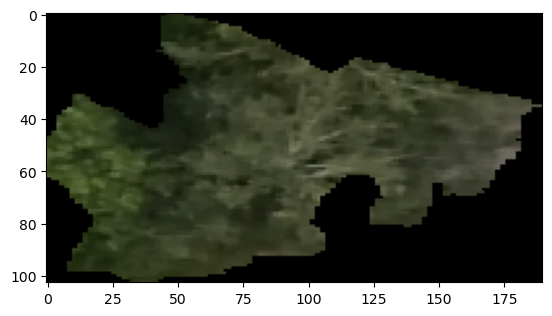

In [56]:
i = np.random.randint(0, 512)
plt.imshow(np.moveaxis(data[i][0][0], 0, -1)[:, :, :3])

In [57]:
def extract_image_features(image, levels=8, ks=1):
    image = np.squeeze(image)
    features = []
    features.extend(np.mean(image, axis=(1, 2)))
    features.extend(np.std(image, axis=(1, 2)))

    gray_image = skimage.color.rgb2gray(np.moveaxis(image[:3, :, :], 0, -1))
    gray_image = skimage.util.img_as_ubyte(gray_image)

    asms = fast_glcm.fast_glcm_ASM(gray_image, levels=levels, ks=ks)
    contrasts = fast_glcm.fast_glcm_contrast(gray_image, levels=levels, ks=ks)
    dissimilarities = fast_glcm.fast_glcm_dissimilarity(gray_image, levels=levels, ks=ks)
    entropies = fast_glcm.fast_glcm_entropy(gray_image, levels=levels, ks=ks)
    homogeneities = fast_glcm.fast_glcm_homogeneity(gray_image, levels=levels, ks=ks)

    features.append(np.mean(asms))
    features.append(np.mean(contrasts))
    features.append(np.mean(dissimilarities))
    features.append(np.mean(entropies))
    features.append(np.mean(homogeneities))

    features.append(np.std(asms))
    features.append(np.std(contrasts))
    features.append(np.std(dissimilarities))
    features.append(np.std(entropies))
    features.append(np.std(homogeneities))

    features.extend(image.max(axis=(1, 2)))
    features.extend(np.where(image > 0, image, np.inf).min(axis=(1, 2)))
    features.append(np.sum(image[3, :, :] > 0) / (image.shape[1] * image.shape[2]))
    axis_0, axis_1 = image[3, :, :].nonzero()
    features.append(axis_0[-1] - axis_0[0])
    features.append(axis_1[-1] - axis_1[0])
    return features

In [58]:
rand_ks = 51
X = np.array(Parallel(n_jobs=-1)(delayed(extract_image_features)(img, ks=rand_ks) for (img, _) in tqdm(data)))
y = np.array([target for (_, target) in tqdm(data)])

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

In [59]:
# ks_list = [2*i + 1 for i in range(19, 26)]
# C_list = [10**i for i in range(0, 6)]
# gamma_list = [10**-i for i in range(0, 6)]


kf = StratifiedKFold(shuffle=True)
results_table = []

rand_C = 10
rand_gamma = 0.01
cv_accuracies = []

for i, (train_index, val_index) in enumerate(kf.split(X, ys)):
    X_train = X[train_index]
    y_train = y[train_index]

    X_val = X[val_index]
    y_val = y[val_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    svc = SVC(C=rand_C, gamma=rand_gamma)
    svc.fit(X_train_scaled, y_train)
    cv_accuracies.append(classification_report(y_val, svc.predict(X_val_scaled), output_dict=True)["accuracy"])

    results_table.append({
        "ks": rand_ks,
        "C": rand_C,
        "gamma": rand_gamma,
        "accuracy": np.mean(cv_accuracies)
    })

In [60]:
pd.DataFrame(results_table)

,ks,C,gamma,accuracy
0,51,10,0.01,0.660194
1,51,10,0.01,0.616505
2,51,10,0.01,0.636493
3,51,10,0.01,0.629331
4,51,10,0.01,0.636798


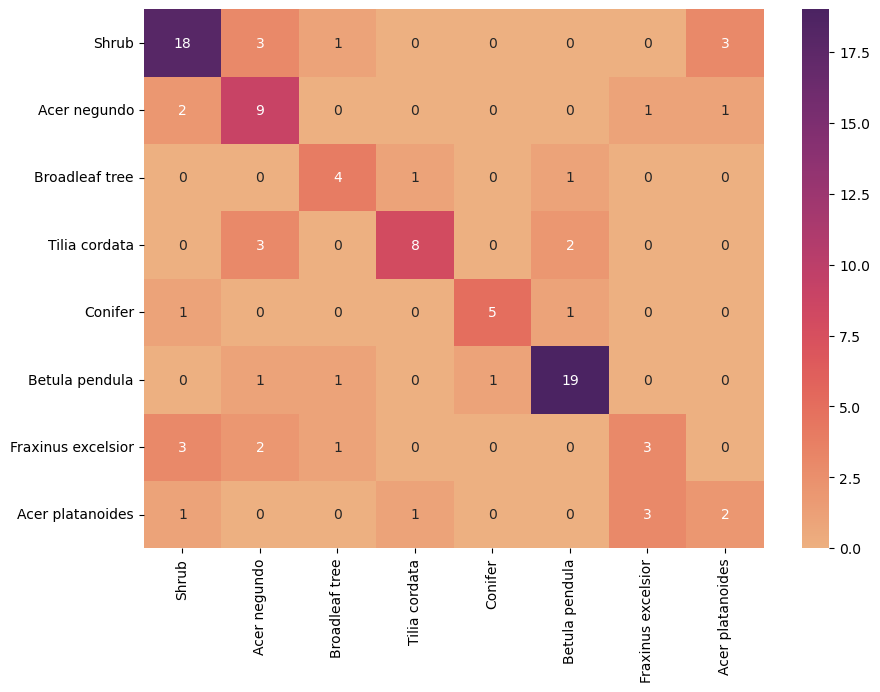

In [61]:
from sklearn.metrics import confusion_matrix


df_cm = pd.DataFrame(confusion_matrix(y_val, svc.predict(X_val_scaled)), index=data.label_map.keys(), columns=data.label_map.keys())
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, cmap="flare", annot=True)
plt.show()